# PARAMETERS

In [1]:
####### INFERENCE CONFIGURATION

class CFG:
    
    # environment
    cpu_workers = 2  # no. CPU cores (data loading)

    # general
    seed = 13353  # random state
    
    # data
    num_folds = 5   # no. CV folds
    num_cuts  = 12  # no. target cuts for stratified split
    num_reps  = 3   # no. repititions of CV
    
    # inference
    batch_size = 32       # no. cases per batch    
    clip       = [-4, 2]  # trim predictions (min, max)
    
    # blending
    use_folds   = 5        # no. folds to use in blends
    use_reps    = 2        # no. bags to use in blends
    fold_blend  = 'amean'  # how to blend folds ['amean', 'median']
    rep_blend   = 'amean'  # how to blend bags ['amean', 'median']
    model_blend = 'amean'  # how to blend models ['amean', 'median']
    
    # stacking 
    w_stack         = 0.00  #0.45  # weight of stacking in final ensemble
    lgb_reps        = 3     # no. bags for stacking
    lgb_folds       = 5     # no. folds for stacking
    lgb_stop_rounds = 200   # no. early stopping rounds
    lgb_params      = {'objective':         'regression',
                       'metrics':           'rmse',
                       'n_estimators':      10000,
                       'learning_rate':     0.01,
                       'num_leaves':        6,
                       'max_depth':         4,
                       'min_child_samples': 20,
                       'subsample':         0.6,
                       'colsample_bytree':  0.6,
                       'reg_alpha':         0.01,
                       'reg_lambda':        0.01,
                       'silent':            True,
                       'verbosity':         -1,
                       'n_jobs' :           -1,
                       'random_state':      13353}
    
    # public kenels
    w_public = 0.20
    
    # paths
    data_path = '../input/commonlitreadabilityprize/'
    out_path  = ''
    
    # models
    models = [
             ##################################################################
             #'../input/readability-training-v33/', # roberta-base
             #'../input/readability-training-v34/', # roberta-base
             #'../input/readability-training-v37/', # roberta-base
             #'../input/readability-v40/',          # albert-large-v2
             #'../input/readability-training-v41/', # roberta-base
             #'../input/readability-v46/',          # bert-base-uncased
             #'../input/readability-training-v48/', # roberta-base [pretrained]
             #'../input/readability-v49/',          # distilbert-base-uncased
             #'../input/readability-v50/',          # facebook/bart-base
             #'../input/readability-v58/',          # distilbert-base-uncased
             #'../input/readability-v72/',          # bert-large-uncased
             #'../input/readability-v38/',          # roberta-large
             #'../input/readability-training-v74/', # electra-base
             #'../input/readability-v78/',           # electra-base
             ##################################################################
             '../input/readability-v36/',           # roberta-large
             '../input/readability-v47/',           # distilroberta-base
             '../input/readability-training-v52/',  # roberta-base
             '../input/readability-training-v55/',  # roberta-base 
             '../input/readability-training-v56/',  # roberta-base [pretrained]
             '../input/readability-training-v59/',  # distilbert-base-uncased
             '../input/readability-v62/',           # roberta-large
             '../input/readability-v69/',           # bert-base-uncased
             ##################################################################
             ]

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

# PREPARATIONS

In [3]:
####### PACKAGES

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import os
import sys
import time
import pickle
import random

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from transformers import AutoModel, AutoTokenizer

import lightgbm as lgb

import warnings
import gc; gc.enable()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sys.path.append('../input/accelerate/accelerate-main')
from src.accelerate import Accelerator, DistributedType

In [4]:
####### MODULES

# source
sys.path.append('../input/readability-code')  

# utilities
from utilities import *

# data
from data import TextData, collate_fn

# model
from model import get_model

In [5]:
####### ENVIRONMENT SETTINGS

pd.options.display.max_columns = 100  # maximum displayed columns
warnings.filterwarnings('ignore')     # ignoring warnings
seed_everything(CFG['seed'])          # random seed

- setting random seed to 13353...


# DATA PREP

In [6]:
####### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'test.csv')

# display
print('test shape: {}'.format(sub.shape))
display(sub.head())

test shape: (7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [7]:
####### IMPORT OOF PREDS

for m in CFG['models']:

    tmp_train_preds         = pd.read_csv(m + 'oof.csv')
    tmp_train_preds         = tmp_train_preds[['id', 'url_legal', 'license', 'excerpt', 'target', 
                               'seq_length', 'standard_error', 'target_cat'] + \
                              ['fold' + str(r) for r in range(CFG['num_reps'])] + \
                              ['pred_rep' + str(r) for r in range(CFG['num_reps'])]]
    tmp_train_preds.columns = ['id', 'url_legal', 'license', 'excerpt', 'target', 
                               'seq_length', 'standard_error', 'target_cat'] + \
                              ['fold' + str(r) for r in range(CFG['num_reps'])] + \
                              [str(m) + 'pred_rep' + str(r) for r in range(CFG['num_reps'])]

    if m == CFG['models'][0]:
        train_preds = tmp_train_preds        
    else:
        train_preds = train_preds.merge(tmp_train_preds[['id'] + [str(m) + 'pred_rep' + str(r) for r in range(CFG['num_reps'])]], how = 'left', on = 'id')
    
train_preds = train_preds[['id', 'target', 'target_cat'] + list(train_preds.filter(like = 'pred').columns)]
train_preds.shape

(2834, 27)

# BLENDING

In [8]:
####### CHECK OOF PERFORMANCE

# sort models by performance
weights = []
for model_idx, m in enumerate(CFG['models']):
    score = 0
    for rep in range(CFG['use_reps']):
        score += get_score(train_preds['target'], train_preds[str(m) + 'pred_rep' + str(rep)]) / CFG['use_reps']
    weights.append(score)
sorted_ids     = list(np.argsort(np.array(weights)))
sorted_weights = [weights[i] for i in sorted_ids]
CFG['models']  = [CFG['models'][i] for i in sorted_ids]

# display performance 
print('-' * 47)
print('{:<5}{:<36}{:>5}'.format('ID', 'Model', 'Score'))
print('-' * 47)
for model_idx, m in enumerate(CFG['models']):
    print('{:<5}{:<36}{:.4f}'.format(model_idx + 1, m, sorted_weights[model_idx]))
print('-' * 47)

-----------------------------------------------
ID   Model                               Score
-----------------------------------------------
1    ../input/readability-training-v52/  0.4756
2    ../input/readability-training-v55/  0.4756
3    ../input/readability-training-v56/  0.4758
4    ../input/readability-v62/           0.4799
5    ../input/readability-v36/           0.4833
6    ../input/readability-v47/           0.4863
7    ../input/readability-v69/           0.4940
8    ../input/readability-training-v59/  0.4992
-----------------------------------------------


In [9]:
####### CHECK BAGGING PERFORMANCE

# sort models by performance
weights = []
for model_idx, m in enumerate(CFG['models']):
    rep_preds = [str(m) + 'pred_rep' + str(rep) for rep in range(CFG['use_reps'])]
    pred      = compute_blend(train_preds, rep_preds, CFG['fold_blend'], CFG)
    score     = get_score(train_preds['target'], pred)
    weights.append(score)
sorted_ids     = list(np.argsort(np.array(weights)))
sorted_weights = [weights[i] for i in sorted_ids]
CFG['models']  = [CFG['models'][i] for i in sorted_ids]

# display performance 
print('-' * 50)
print('{:<5}{:<36}{:>5}'.format('ID', 'Model', 'Bag score'))
print('-' * 50) 
for model_idx, m in enumerate(CFG['models']):
    print('{:<5}{:<36}{:.4f}'.format(model_idx + 1, m, sorted_weights[model_idx]))
print('-' * 50)

--------------------------------------------------
ID   Model                               Bag score
--------------------------------------------------
1    ../input/readability-training-v56/  0.4689
2    ../input/readability-training-v55/  0.4693
3    ../input/readability-training-v52/  0.4696
4    ../input/readability-v62/           0.4739
5    ../input/readability-v36/           0.4769
6    ../input/readability-v47/           0.4804
7    ../input/readability-v69/           0.4876
8    ../input/readability-training-v59/  0.4938
--------------------------------------------------


In [10]:
####### CHECK MODEL BLEND PERFORMANCE

# list of blends
blend_list = ['amean', 'median']

# blend bagged predictions
for model_idx, m in enumerate(CFG['models']):
    rep_preds       = [str(m) + 'pred_rep' + str(rep) for rep in range(CFG['use_reps'])]
    train_preds[m] = compute_blend(train_preds, rep_preds, CFG['fold_blend'], CFG)

# compute predcitions
preds = CFG['models']
for blend in blend_list:
    train_preds[blend] = compute_blend(train_preds, preds, blend, CFG)

# compute performance
print('-' * 16)
print('{:<10}{:>5}'.format('Blend', 'Score'))
print('-' * 16)
for blend in blend_list:
    score = get_score(train_preds['target'], train_preds[blend])
    print('{:<10}{:>5.4f}'.format(blend, score))    
print('-' * 16)

----------------
Blend     Score
----------------
amean     0.4586
median    0.4595
----------------


In [11]:
####### EXPORT BEST OOF BLEND

oof_blend         = train_preds[['id', 'target']].copy()
oof_blend['pred'] = train_preds[CFG['model_blend']]
oof_blend.to_csv(CFG['out_path'] + 'oof_{}.csv'.format(CFG['model_blend']), index = False)
oof_blend.head()

,id,target,pred
0,85aa80a4c,-0.315372,-0.142832
1,057f69731,-1.126248,-0.852753
2,5e7c0b55b,-1.009999,-1.160706
3,66f0a9ff1,-2.386485,-1.456543
4,bdd8488dd,-0.473702,-0.444412


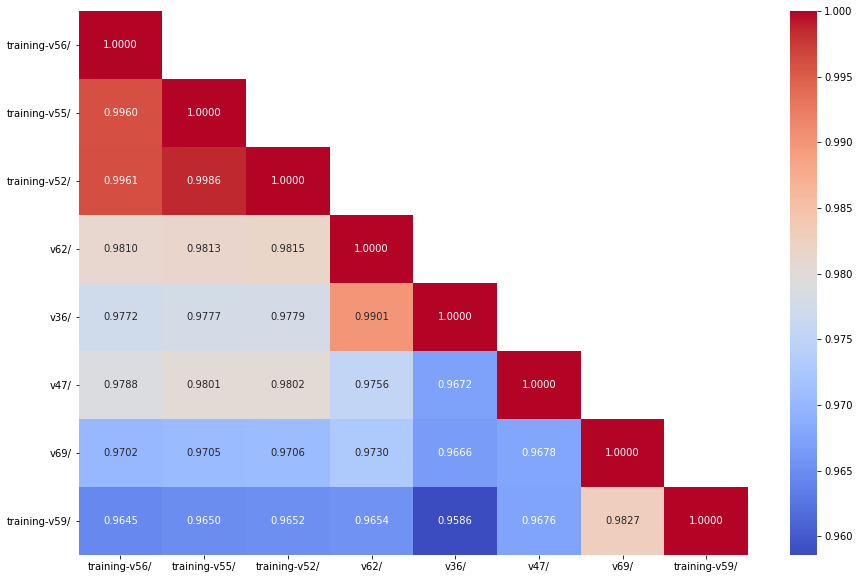

In [12]:
####### CHECK MODEL OOF CORRELATION

corr    = train_preds[CFG['models']].corr()
corr    = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
fig, ax = plt.subplots(figsize = (15, 10))
ticks   = [m.replace('../input/readability-', '') for m in CFG['models']]
hmap    = sns.heatmap(corr, cmap = 'coolwarm', annot = corr, fmt = '.4f', xticklabels = ticks, yticklabels = ticks)
plt.yticks(rotation = 0)
plt.show()

# INFERENCE

In [13]:
####### LOAD MODEL CONFIGURATIONS

import pickle

CFGs = []

for model in CFG['models']:
    
    model_CFG = pickle.load(open(model + 'configuration.pkl', 'rb'))  
    
    if model_CFG['backbone'] == 'albert-large-v2':
        model_CFG['backbone'] = '/kaggle/input/transformers/albert-large-v2'  
        
    elif model_CFG['backbone'] == 'bert-base-uncased':
        model_CFG['backbone'] = '/kaggle/input/transformers/bert-base-uncased' 
        
    elif model_CFG['backbone'] == 'bert-large-uncased':
        model_CFG['backbone'] = '/kaggle/input/transformers/bert-large-uncased' 
        
    elif model_CFG['backbone'] == 'distilbert-base-uncased':
        model_CFG['backbone'] = '/kaggle/input/transformers/distilbert-base-uncased'
        
    elif model_CFG['backbone'] == 'distilroberta-base':
        model_CFG['backbone'] = '/kaggle/input/transformers/distilroberta-base'
        
    elif model_CFG['backbone'] == 'facebook/bart-base':
        model_CFG['backbone'] = '/kaggle/input/transformers/facebook-bart-base'    
        
    elif model_CFG['backbone'] == 'facebook/bart-large':
        model_CFG['backbone'] = '/kaggle/input/transformers/facebook-bart-large'  
        
    elif model_CFG['backbone'] == 'funnel-transformer/base':
        model_CFG['backbone'] = '/kaggle/input/transformers/funnel-transformer-base'    
        
    elif model_CFG['backbone'] == 'funnel-transformer/large':
        model_CFG['backbone'] = '/kaggle/input/transformers/funnel-transformer-large' 
        
    elif model_CFG['backbone'] == 'roberta-base' or model_CFG['backbone'] == '../input/clrp-roberta-base/clrp_roberta_base':
        model_CFG['backbone'] = '/kaggle/input/transformers/roberta-base'
        
    elif model_CFG['backbone'] == 'roberta-large':
        model_CFG['backbone'] = '/kaggle/input/transformers/roberta-large'   
                
    elif model_CFG['backbone'] == 't5-base':
        model_CFG['backbone'] = '/kaggle/input/transformers/t5-base'    
        
    elif model_CFG['backbone'] == 't5-large':
        model_CFG['backbone'] = '/kaggle/input/transformers/t5-large' 
        
    elif model_CFG['backbone'] == 'xlnet-base-cased':
        model_CFG['backbone'] = '/kaggle/input/transformers/xlnet-base-cased'    
        
    elif model_CFG['backbone'] == 'xlnet-large-cased':
        model_CFG['backbone'] = '/kaggle/input/transformers/xlnet-large-cased'  
        
        
    CFGs.append(model_CFG)
    
print('Numer of models:', len(CFGs))

Numer of models: 8


In [14]:
####### PRODUCE TEST PREDS 

# timer
cv_start = time.time()
gc.collect()

# counter
all_counter  = 0
rep_counter  = 0
fold_counter = 0

# placeholder
all_nn_preds = None

# progress bar
pbar = tqdm(range(CFG['use_folds'] * CFG['use_reps'] * len(CFG['models'])))

# loop through models
for model_idx in range(len(CFG['models'])):
       
    # get tokenizer
    tokenizer = AutoTokenizer.from_pretrained(CFGs[model_idx]['backbone'])
    
    # get data
    test_dataset = TextData(df          = sub, 
                            tokenizer   = tokenizer,
                            max_len     = CFGs[model_idx]['max_len'],
                            padding     = False,
                            p_translate = 0,
                            labeled     = False,
                            return_sd   = False)
            
    # loop through folds
    for rep_idx in range(CFG['use_reps']):
               
        # loop through folds
        for fold_idx in range(CFG['use_folds']):
            
            # initialize accelerator
            accelerator = Accelerator(device_placement = True,
                                      fp16             = CFGs[model_idx]['use_fp16'],
                                      split_batches    = False)
            
            # get loader
            test_loader = DataLoader(dataset     = test_dataset, 
                                     batch_size  = CFG['batch_size'], 
                                     shuffle     = False,
                                     collate_fn  = lambda b: collate_fn(b, tokenizer, CFGs[model_idx], False),
                                     num_workers = CFG['cpu_workers'],
                                     drop_last   = False,
                                     pin_memory  = False)
            
            # get model 
            model = get_model(CFG        = CFGs[model_idx], 
                              pretrained = CFG['models'][model_idx] + 'weights_rep{}_fold{}.pth'.format(rep_counter, fold_counter),
                              silent     = True)
            
            # device placement
            model, test_loader = accelerator.prepare(model, test_loader)
    
            # switch regime
            model.eval()

            # placeholders
            PREDS = []
            
            # loop through batches
            with torch.no_grad():
                for batch_idx, (inputs, masks, token_type_ids) in enumerate(test_loader):
                    
                    # forward pass
                    preds = model(inputs, masks, token_type_ids)
                    preds = preds['logits'].squeeze(-1)

                    # store predictions
                    PREDS.append(accelerator.gather(preds).detach().cpu())

            # store predictions
            nn_preds     = pd.DataFrame(np.concatenate(PREDS), columns = [CFG['models'][model_idx] + 'rep' + str(rep_idx) + '_fold' + str(fold_idx)])
            all_nn_preds = pd.concat([all_nn_preds, nn_preds], axis = 1)

            # update counters
            pbar.update()
            all_counter  += 1
            fold_counter += 1
            if fold_counter == CFG['num_folds']:
                fold_counter = 0

            # clear memory
            del model
            del inputs, masks, token_type_ids, preds, PREDS, nn_preds
            gc.collect()            
            
        # update counters
        rep_counter += 1
        if rep_counter == CFG['num_reps']:
            rep_counter = 0

    # clear memory
    del accelerator, test_loader, test_dataset, tokenizer
    gc.collect()
        
# print performance
print('Finished {} preds in {:.2f} mins'.format(all_counter, (time.time() - cv_start) / 60))
all_nn_preds.head()

  0%|          | 0/80 [00:00<?, ?it/s]

Some weights of the model checkpoint at /kaggle/input/transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /kaggle/input/transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']

Finished 80 preds in 12.64 mins


,../input/readability-training-v56/rep0_fold0,../input/readability-training-v56/rep0_fold1,../input/readability-training-v56/rep0_fold2,../input/readability-training-v56/rep0_fold3,../input/readability-training-v56/rep0_fold4,../input/readability-training-v56/rep1_fold0,../input/readability-training-v56/rep1_fold1,../input/readability-training-v56/rep1_fold2,../input/readability-training-v56/rep1_fold3,../input/readability-training-v56/rep1_fold4,../input/readability-training-v55/rep0_fold0,../input/readability-training-v55/rep0_fold1,../input/readability-training-v55/rep0_fold2,../input/readability-training-v55/rep0_fold3,../input/readability-training-v55/rep0_fold4,../input/readability-training-v55/rep1_fold0,../input/readability-training-v55/rep1_fold1,../input/readability-training-v55/rep1_fold2,../input/readability-training-v55/rep1_fold3,../input/readability-training-v55/rep1_fold4,../input/readability-training-v52/rep0_fold0,../input/readability-training-v52/rep0_fold1,../input/readability-training-v52/rep0_fold2,../input/readability-training-v52/rep0_fold3,../input/readability-training-v52/rep0_fold4,../input/readability-training-v52/rep1_fold0,../input/readability-training-v52/rep1_fold1,../input/readability-training-v52/rep1_fold2,../input/readability-training-v52/rep1_fold3,../input/readability-training-v52/rep1_fold4,../input/readability-v62/rep0_fold0,../input/readability-v62/rep0_fold1,../input/readability-v62/rep0_fold2,../input/readability-v62/rep0_fold3,../input/readability-v62/rep0_fold4,../input/readability-v62/rep1_fold0,../input/readability-v62/rep1_fold1,../input/readability-v62/rep1_fold2,../input/readability-v62/rep1_fold3,../input/readability-v62/rep1_fold4,../input/readability-v36/rep0_fold0,../input/readability-v36/rep0_fold1,../input/readability-v36/rep0_fold2,../input/readability-v36/rep0_fold3,../input/readability-v36/rep0_fold4,../input/readability-v36/rep1_fold0,../input/readability-v36/rep1_fold1,../input/readability-v36/rep1_fold2,../input/readability-v36/rep1_fold3,../input/readability-v36/rep1_fold4,../input/readability-v47/rep0_fold0,../input/readability-v47/rep0_fold1,../input/readability-v47/rep0_fold2,../input/readability-v47/rep0_fold3,../input/readability-v47/rep0_fold4,../input/readability-v47/rep1_fold0,../input/readability-v47/rep1_fold1,../input/readability-v47/rep1_fold2,../input/readability-v47/rep1_fold3,../input/readability-v47/rep1_fold4,../input/readability-v69/rep0_fold0,../input/readability-v69/rep0_fold1,../input/readability-v69/rep0_fold2,../input/readability-v69/rep0_fold3,../input/readability-v69/rep0_fold4,../input/readability-v69/rep1_fold0,../input/readability-v69/rep1_fold1,../input/readability-v69/rep1_fold2,../input/readability-v69/rep1_fold3,../input/readability-v69/rep1_fold4,../input/readability-training-v59/rep0_fold0,../input/readability-training-v59/rep0_fold1,../input/readability-training-v59/rep0_fold2,../input/readability-training-v59/rep0_fold3,../input/readability-training-v59/rep0_fold4,../input/readability-training-v59/rep1_fold0,../input/readability-training-v59/rep1_fold1,../input/readability-training-v59/rep1_fold2,../input/readability-training-v59/rep1_fold3,../input/readability-training-v59/rep1_fold4
0,-0.326416,-0.580566,-0.300537,-0.472412,-0.316895,-0.630371,-0.528320,-0.325684,-0.364258,-0.224731,-0.330322,-0.605469,-0.522461,-0.418701,-0.295166,-0.383301,-0.569336,-0.391846,-0.332031,-0.332520,-0.520508,-0.510254,-0.383301,-0.338135,-0.260986,-0.383057,-0.681152,-0.522949,-0.420166,-0.267578,-0.541016,-0.475586,-0.411377,-0.412598,-0.290527,-0.684570,-0.377441,-0.521484,-0.196045,-0.263428,-0.188965,-0.347656,-0.534668,-0.338623,-0.337891,-0.418457,-0.485107,-0.386963,-0.279785,-0.316162,-0.751465,-0.613281,-0.615234,-0.567383,-0.595215,-0.230591,-0.675293,-0.700684,-0.457275,-0.491455,-0.290039,-0.467285,-0.242065,-0.266113,-0.374268,-0.218140,-0.379395,-0.385498,-0.366211,-0.371094,-0.124634,-0.459961,-0.415283,-0.208984,-0.205811,-0.3359

# BLENDING

In [15]:
######## BLEND FOLD PREDICTIONS

# copy predictions
test_preds_nn       = all_nn_preds.copy()
test_preds_nn['id'] = sub['id']

# blend folds
print('Blending fold predictions with: ' + CFG['fold_blend'])
for m in CFG['models']:
    for rep in range(CFG['use_reps']):
        preds = [m + 'rep' + str(rep) + '_fold' + str(fold) for fold in range(CFG['use_folds'])]
        test_preds_nn[m + 'rep' + str(rep)] = compute_blend(test_preds_nn, preds, CFG['fold_blend'], CFG)
        test_preds_nn.drop(preds, axis = 1, inplace = True)
test_preds_nn.head()

Blending fold predictions with: amean


,id,../input/readability-training-v56/rep0,../input/readability-training-v56/rep1,../input/readability-training-v55/rep0,../input/readability-training-v55/rep1,../input/readability-training-v52/rep0,../input/readability-training-v52/rep1,../input/readability-v62/rep0,../input/readability-v62/rep1,../input/readability-v36/rep0,../input/readability-v36/rep1,../input/readability-v47/rep0,../input/readability-v47/rep1,../input/readability-v69/rep0,../input/readability-v69/rep1,../input/readability-training-v59/rep0,../input/readability-training-v59/rep1
0,c0f722661,-0.399365,-0.414673,-0.434424,-0.401807,-0.402637,-0.454980,-0.426221,-0.408594,-0.349561,-0.377295,-0.628516,-0.511060,-0.327954,-0.344067,-0.282935,-0.344092
1,f0953f0a5,-0.780273,-0.769824,-0.666016,-0.634668,-0.639307,-0.674316,-0.391333,-0.421143,-0.443506,-0.462402,-0.724316,-0.707031,-0.318970,-0.284863,-0.477441,-0.507520
2,0df072751,-0.383325,-0.415186,-0.415552,-0.432227,-0.462695,-0.443994,-0.433960,-0.397656,-0.399951,-0.426465,-0.420996,-0.331641,-0.378467,-0.370313,-0.314819,-0.415283
3,04caf4e0c,-2.498828,-2.493750,-2.435547,-2.542188,-2.465625,-2.453125,-2.265234,-2.217188,-2.213672,-2.345313,-2.540234,-2.474219,-2.159180,-2.159375,-2.498438,-2.569141
4,0e63f8bea,-1.689844,-1.763672,-1.780469,-1.778711,-1.763672,-1.776563,-1.863867,-1.852734,-1.862109,-1.901367,-1.809375,-1.766992,-1.843750,-1.837109,-1.844727,-1.897852


In [16]:
######## BLEND BAG PREDICTIONS

print('Blending bag predictions with: ' + CFG['rep_blend'])
for m in CFG['models']:
    preds            = test_preds_nn.filter(like = m).columns
    test_preds_nn[m] = compute_blend(test_preds_nn, preds, CFG['rep_blend'], CFG)
    test_preds_nn.drop(preds, axis = 1, inplace = True)
test_preds_nn.head()

Blending bag predictions with: amean


,id,../input/readability-training-v56/,../input/readability-training-v55/,../input/readability-training-v52/,../input/readability-v62/,../input/readability-v36/,../input/readability-v47/,../input/readability-v69/,../input/readability-training-v59/
0,c0f722661,-0.407019,-0.418115,-0.428809,-0.417407,-0.363428,-0.569788,-0.336011,-0.313513
1,f0953f0a5,-0.775049,-0.650342,-0.656812,-0.406238,-0.452954,-0.715674,-0.301917,-0.492480
2,0df072751,-0.399255,-0.423889,-0.453345,-0.415808,-0.413208,-0.376318,-0.374390,-0.365051
3,04caf4e0c,-2.496289,-2.488867,-2.459375,-2.241211,-2.279492,-2.507227,-2.159277,-2.533789
4,0e63f8bea,-1.726758,-1.779590,-1.770117,-1.858301,-1.881738,-1.788184,-1.840430,-1.871289


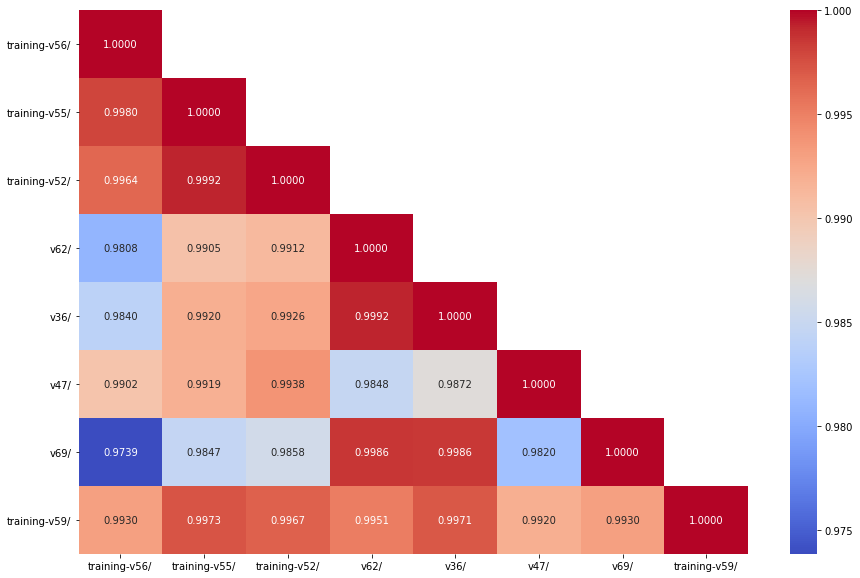

In [17]:
####### CHECK MODEL TEST CORRELATION

corr    = test_preds_nn[CFG['models']].corr()
corr    = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
fig, ax = plt.subplots(figsize = (15, 10))
ticks   = [m.replace('../input/readability-', '') for m in CFG['models']]
hmap    = sns.heatmap(corr, cmap = 'coolwarm', annot = corr, fmt = '.4f', xticklabels = ticks, yticklabels = ticks)
plt.yticks(rotation = 0)
plt.show()

In [18]:
####### BLEND MODEL PREDICTIONS

print('Blending model predictions with: ' + CFG['model_blend'])
preds = test_preds_nn.filter(like = 'input').columns
test_preds_nn['pred'] = compute_blend(test_preds_nn, preds, CFG['model_blend'], CFG) 
test_preds_nn.head()

Blending model predictions with: amean


,id,../input/readability-training-v56/,../input/readability-training-v55/,../input/readability-training-v52/,../input/readability-v62/,../input/readability-v36/,../input/readability-v47/,../input/readability-v69/,../input/readability-training-v59/,pred
0,c0f722661,-0.407019,-0.418115,-0.428809,-0.417407,-0.363428,-0.569788,-0.336011,-0.313513,-0.406761
1,f0953f0a5,-0.775049,-0.650342,-0.656812,-0.406238,-0.452954,-0.715674,-0.301917,-0.492480,-0.556433
2,0df072751,-0.399255,-0.423889,-0.453345,-0.415808,-0.413208,-0.376318,-0.374390,-0.365051,-0.402658
3,04caf4e0c,-2.496289,-2.488867,-2.459375,-2.241211,-2.279492,-2.507227,-2.159277,-2.533789,-2.395691
4,0e63f8bea,-1.726758,-1.779590,-1.770117,-1.858301,-1.881738,-1.788184,-1.840430,-1.871289,-1.814551


In [19]:
####### EXPORT BEST TEST BLEND

test_blend = test_preds_nn[['id', 'pred']].copy()   
test_blend.to_csv('sub_{}.csv'.format(CFG['model_blend']), index = False)
test_blend.head()

,id,pred
0,c0f722661,-0.406761
1,f0953f0a5,-0.556433
2,0df072751,-0.402658
3,04caf4e0c,-2.395691
4,0e63f8bea,-1.814551


# STACKING

In [20]:
####### COPY PREDICTIONS

df_train = train_preds.copy()
df_test  = test_preds_nn.copy()

In [21]:
####### ADD TRAIN FEATURES

train_feats = pd.read_csv('/kaggle/input/readability-features/features_train.csv')
train_feats.drop(['url_legal', 'license', 'excerpt', 'target'], axis = 1, inplace = True)
df_train = df_train.merge(train_feats, how = 'left', on = 'id')
df_train.head()

,id,target,target_cat,../input/readability-v36/pred_rep0,../input/readability-v36/pred_rep1,../input/readability-v36/pred_rep2,../input/readability-v47/pred_rep0,../input/readability-v47/pred_rep1,../input/readability-v47/pred_rep2,../input/readability-training-v52/pred_rep0,../input/readability-training-v52/pred_rep1,../input/readability-training-v52/pred_rep2,../input/readability-training-v55/pred_rep0,../input/readability-training-v55/pred_rep1,../input/readability-training-v55/pred_rep2,../input/readability-training-v56/pred_rep0,../input/readability-training-v56/pred_rep1,../input/readability-training-v56/pred_rep2,../input/readability-training-v59/pred_rep0,../input/readability-training-v59/pred_rep1,../input/readability-training-v59/pred_rep2,../input/readability-v62/pred_rep0,../input/readability-v62/pred_rep1,../input/readability-v62/pred_rep2,../input/readability-v69/pred_rep0,../input/readability-v69/pred_rep1,../input/readability-v69/pred_rep2,../input/readability-training-v56/,../input/readability-training-v55/,../input/readability-training-v52/,../input/readability-v62/,../input/readability-v36/,../input/readability-v47/,../input/readability-v69/,../input/readability-training-v59/,amean,median,standard_error,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog2,text_standard,mean_parse_tree_depth,total_sentences,...,semicolons,quotes,nonstop_char_count,nonstop_word_count,words_per_sentence,ents_per_sentence,chars_per_sentence,chars_per_word,punctutation_per_word,mean_adj,mean_adp,mean_adv,mean_aux,mean_cconj,mean_det,mean_intj,mean_noun,mean_num,mean_part,mean_pron,mean_propn,mean_punct,mean_sconj,mean_verb,mean_x,mean_space,mean_sym,complex_words,long_words,kincaid,ari,coleman_liau,flesch,gunning_fog,lix,smog,rix,dale_chall,tobeverb,auxverb,conjunction,pronoun,preposition,nominalization,pronoun_b,interrogative,article,subordination,conjunction_b,preposition_b
0,85aa80a4c,-0.315372,7,-0.211182,-0.156738,-0.255371,-0.092651,-0.126099,-0.195068,-0.075256,-0.080505,-0.219849,-0.005001,-0.157104,-0.129272,-0.017303,-0.143555,-0.205200,-0.152588,-0.250244,-0.130127,-0.245239,-0.096924,-0.161621,-0.359863,-0.115051,-0.346680,-0.080429,-0.081053,-0.077881,-0.171082,-0.183960,-0.109375,-0.237457,-0.201416,-0.142832,-0.140228,0.480805,71.24,8.8,7.5,6.90,7.8,6.06,17,8.500000,8.65,9.0,0.805310,17,...,0,12,8.820896,1.746269,9.941176,0.176471,55.117647,5.544379,3.117647,1.08,1.08,1.67,0.92,0.58,1.25,0.25,1.83,0.00,0.58,2.00,0.42,3.58,0.08,2.58,0.0,0.92,NaN,12,26,9.722558,12.427926,7.541115,76.415078,14.257364,43.782946,10.745967,4.333333,7.628832,5,5,7,30,22,0,0,0,0,0,0,1
1,057f69731,-1.126248,5,-0.932617,-0.907227,-0.729004,-0.751465,-0.862305,-0.764160,-0.903320,-0.686035,-0.626465,-0.957520,-0.826172,-0.642090,-0.791016,-0.720215,-0.596191,-0.711426,-0.622559,-0.568848,-1.217773,-0.930176,-0.874512,-0.971191,-0.853027,-0.947754,-0.755615,-0.891846,-0.794678,-1.073975,-0.919922,-0.806885,-0.912109,-0.666992,-0.852753,-0.849365,0.477028,66.20,12.2,11.5,8.19,14.1,6.44,15,19.666667,13.63,12.0,1.413462,6,...,0,0,8.813559,1.508475,30.166667,1.833333,162.666667,5.392265,2.500000,1.83,3.67,2.50,2.33,0.67,4.50,0.00,3.83,0.50,1.67,2.83,1.17,2.14,1.17,4.50,0.0,1.00,NaN,15,24,35.199064,44.764492,8.156792,9.236243,40.608556,106.334225,18.000000,12.000000,10.807255,9,7,5,19,25,0,1,0,0,0,0,0
2,5e7c0b55b,-1.009999,5,-1.081055,-1.118164,-0.940918,-1.053711,-1.291992,-1.281250,-1.329102,-1.380859,-1.110352,-1.357422,-1.338867,-1.095703,-1.258789,-1.320312,-1.091797,-0.928223,-1.145508,-0.876465,-1.044922,-1.076172,-0.935547,-0.937988,-0.908203,-0.829590,-1.289551,-1.348145,-1.354980,-1.060547,-1.099609,-1.172852,-0.923096,-1.036865,-1.160706,-1.136230,0.496148,74.02,8.1,8.5,7.38,9.9,6.51,20,10.800000,9.89,7.0,1.029126,8,...,2,0,9.016667,1.550000,22.125000,1.000000,119.625000,5.406780,2.125000,1.25,2.62,1.38,2.00,1.25,

In [22]:
####### COMPUTE TEST FEATURES

!pip install '../input/textstat/Pyphen-0.10.0-py3-none-any.whl'
!pip install '../input/textstat/textstat-0.7.0-py3-none-any.whl'
sys.path = ['../input/readability-package'] + sys.path

import readability
import spacy
from textstat import textstat

import re
import en_core_web_sm
import string
import nltk
from nltk.corpus import stopwords

nlp         = en_core_web_sm.load()
STOPWORDS   = stopwords.words("english")
PUNCTUATION = list(string.punctuation)
POS_TAGS    = ["ADJ","ADP","ADV","AUX","CCONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT","SCONJ","VERB","X","SPACE"]


def readability_measurements(passage: str):
    """
    This function uses the readability library for feature engineering.
    It includes textual statistics, readability scales and metric, and some pos stats
    """
    results = readability.getmeasures(passage, lang='en')
    
    complex_words  = results['sentence info']['complex_words']
    long_words     = results['sentence info']['long_words']
    
    kincaid      = results['readability grades']['Kincaid']
    ari          = results['readability grades']['ARI']
    coleman_liau = results['readability grades']['Coleman-Liau']
    flesch       = results['readability grades']['FleschReadingEase']
    gunning_fog  = results['readability grades']['GunningFogIndex']
    lix          = results['readability grades']['LIX']
    smog         = results['readability grades']['SMOGIndex']
    rix          = results['readability grades']['RIX']
    dale_chall   = results['readability grades']['DaleChallIndex']
    
    tobeverb       = results['word usage']['tobeverb']
    auxverb        = results['word usage']['auxverb']
    conjunction    = results['word usage']['conjunction']
    pronoun        = results['word usage']['pronoun']
    preposition    = results['word usage']['preposition']
    nominalization = results['word usage']['nominalization']
    
    pronoun_b     = results['sentence beginnings']['pronoun']
    interrogative = results['sentence beginnings']['interrogative']
    article       = results['sentence beginnings']['article']
    subordination = results['sentence beginnings']['subordination']
    conjunction_b = results['sentence beginnings']['conjunction']
    preposition_b = results['sentence beginnings']['preposition']

    
    return [complex_words, long_words,
            kincaid, ari, coleman_liau, flesch, gunning_fog, lix, smog, rix, dale_chall,
            tobeverb, auxverb, conjunction, pronoun, preposition, nominalization,
            pronoun_b, interrogative, article, subordination, conjunction_b, preposition_b]




def simplify_punctuation(text):
    # from https://github.com/shivam5992/textstat/issues/77
    text = re.sub(r"[,:;()\-]", " ", text)  # Override commas, colons, etc to spaces/
    text = re.sub(r"[\.!?]", ".", text)  # Change all terminators like ! and ? to "."
    text = re.sub(r"^\s+", "", text)  # Remove white space
    text = re.sub(r"[ ]*(\n|\r\n|\r)[ ]*", " ", text)  # Remove new lines
    text = re.sub(r"([\.])[\. ]+", ".", text)  # Change all ".." to "."
    text = re.sub(r"[ ]*([\.])", ". ", text)  # Normalize all "."`
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    text = re.sub(r"\s+$", "", text)  # Remove trailing spaces
    return text


def get_mean_parse_tree_depth(text):
    sentences = text.split(".")
    depths = []
    for doc in list(nlp.pipe(sentences)):
        depths += get_parse_tree_depths(doc)
    return np.mean(depths)


def get_parse_tree_depths(doc):
    return [get_depth(token) for token in doc]


def get_depth(token, depth=0):
    depths = [get_depth(child, depth + 1) for child in token.children]
    return max(depths) if len(depths) > 0 else depth


def get_mean_pos_tags(text):
    sentences       = text.split(".")
    sentence_counts = make_pos_tag_count_lists(sentences)
    num_sentences   = textstat.sentence_count(text)
    mean_pos_tags   = calculate_mean_per_tag(sentence_counts, num_sentences)
    return mean_pos_tags


def make_pos_tag_count_lists(sentences):
    sentence_counts = {}
    for doc in list(nlp.pipe(sentences)):
        pos_counts = get_pos_tag_counts(doc)
        for key in pos_counts:
            if key in sentence_counts:
                sentence_counts[key].append(pos_counts[key])
            else:
                sentence_counts[key] = [pos_counts[key]]
    return sentence_counts


def get_pos_tag_counts(doc):
    pos_counts = {}
    pos_tags = [token.pos_ for token in doc]
    for tag in pos_tags:
        if tag in pos_counts:
            pos_counts[tag] += 1
        else:
            pos_counts[tag] = 1
    return pos_counts


def calculate_mean_per_tag(counts, num_sentences):
    mean_pos_tags = {f"mean_{tag.lower()}": 0 for tag in POS_TAGS}
    for key in counts:
        if len(counts[key]) < num_sentences:
            counts[key] += [0] * (num_sentences - len(counts[key]))
        mean_value = round(np.mean(counts[key]), 2)
        mean_pos_tags["mean_" + key.lower()] = mean_value
    return mean_pos_tags


def get_total_ents(text):
    return len(nlp(text).doc.ents)


def get_mean_nonstop_char_length_word_count(text):
    spans = tokenize_on_stopwords(text)
    return sum([get_num_chars(span) for span in spans]) / len(spans),  sum([get_num_words(span) for span in spans]) / len(spans)


def get_nonstop_proportion(text):
    tokens = nltk.word_tokenize(text)
    nonstop_tokens = [token for token in tokens if token not in STOPWORDS + PUNCTUATION]
    return len(nonstop_tokens) / len(tokens)


def tokenize_on_stopwords(text):
    tokens = nltk.word_tokenize(text)
    spans = []
    current_span = []
    for token in tokens:
        if token not in STOPWORDS + PUNCTUATION:
            current_span.append(token)
        else:
            if len(current_span) > 0:
                spans.append(" ".join(current_span))
            current_span = []
    return spans


def get_num_chars(text):
    return len(text)


def get_num_words(text):
    return len(text.split())


def get_num_unique_words(text):
     return len(set(w for w in text.split()))


def get_num_sentences(text):
    total = text.count(".") + text.count("?") + text.count("!")
    if total == 0:
        return 1
    else:
        return total
    
    
def get_num_semicolons(text):
    total = text.count(";")
    return total


def get_num_quotes(text):
    total = text.count('"')
    return total


def get_num_punctuation(text):
    total = sum(text.count(w) for w in '.,;:!?"')
    return total


def gen_features(text):
    
    '''Compute text features'''
        
    simplified_text = simplify_punctuation(text)

    features = {
        "flesch_reading_ease":          textstat.flesch_reading_ease(simplified_text),
        "smog_index":                   textstat.smog_index(simplified_text),
        "flesch_kincaid_grade":         textstat.flesch_kincaid_grade(simplified_text),
        "coleman_liau_index":           textstat.coleman_liau_index(simplified_text),
        "automated_readability_index":  textstat.automated_readability_index(simplified_text),
        "dale_chall_readability_score": textstat.dale_chall_readability_score(simplified_text),
        "difficult_words":              textstat.difficult_words(simplified_text),
        "linsear_write_formula":        textstat.linsear_write_formula(simplified_text),
        "gunning_fog2":                 textstat.gunning_fog(simplified_text),
        "text_standard":                textstat.text_standard(simplified_text, float_output = True),
        "mean_parse_tree_depth":        get_mean_parse_tree_depth(text),
        "total_sentences":              get_num_sentences(text),
        "total_words":                  get_num_words(text),
        "total_ents":                   get_total_ents(text),
        "total_chars":                  get_num_chars(text),
        "total_punctutation":           get_num_punctuation(text),
        "unique_words":                 get_num_words(text),
        "nonstop_token_proportion":     get_nonstop_proportion(text),
        "semicolons":                   get_num_semicolons(text),
        "quotes":                       get_num_quotes(text),
    }
    
    nonstops = get_mean_nonstop_char_length_word_count(text)
    features['nonstop_char_count'] = nonstops[0]
    features['nonstop_word_count'] = nonstops[1]

    features['words_per_sentence']    = features['total_words']        / features['total_sentences']
    features['ents_per_sentence']     = features['total_ents']         / features['total_sentences']
    features['chars_per_sentence']    = features['total_chars']        / features['total_sentences']
    features['chars_per_word']        = features['total_chars']        / features['total_words']
    features['punctutation_per_word'] = features['total_punctutation'] / features['total_sentences']

    features.update(get_mean_pos_tags(text))
        
    return features


def add_features(data):
    
    feature_data = []

    for text in tqdm(data):
        features = gen_features(text)
        feature_data.append(features)

    return pd.DataFrame(feature_data)


def TF_IDF_W2V(text):
    '''Calculate TF-IDF with word2vec
    '''
    #Load TF-IDF from sklearn
    TFIDF_model = TfidfVectorizer()
    #fit on text
    TFIDF_model.fit(text)
    #create dictionary with word as key
    #and idf as value
    dictionary = dict(zip(TFIDF_model.get_feature_names(), list(TFIDF_model.idf_)))
    #apply set as we need unique features
    TFIDF_words = set(TFIDF_model.get_feature_names())
    #create list which stores TFIDF_W2V
    TFIDF_W2V_vectors = []
    for sentence in text:
        #create empty vector to store result
        vector = np.zeros(300)
        #number of words with valid vector in sentence
        TFIDF_weight =0
        for word in sentence.split(): 
            #if word exist in glove_words and TFIDF_words
            if (word in glove_words) and (word in TFIDF_words):
                #get its vector from glove_words
                vec = word2vec_model[word]
                #calculate TF-IDF for each word
                TFIDF = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                #calculate TF-IDF weighted W2V
                vector += (vec * TFIDF)
                TFIDF_weight += TFIDF
                
        if TFIDF_weight != 0:
            vector /= TFIDF_weight
        TFIDF_W2V_vectors.append(vector)
    return TFIDF_W2V_vectors 


def clean_text(text):
    text = str(text).lower()
    text = re.sub('\n', '', text)
    text = "".join([i for i in text if i not in string.punctuation])
    return text


def tf_idf_features(df: pd.DataFrame):

    text    = df['excerpt'].apply(lambda x: clean_text(x))
    tfidf   = TF_IDF_W2V(text)
    vectors = np.array(tfidf)
        
    return vectors


def get_tf_idf_col_names():
    names = list()
    for i in range(300):
        names.append(f"tf_idf_{i}")
        
    return names


test           = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
test_features  = add_features(test.excerpt.to_list())
test_features  = pd.DataFrame(test_features)
test_features2 = pd.DataFrame(test.excerpt.apply(lambda p : readability_measurements(p)).tolist(), 
                               columns = ["complex_words","long_words",
                                          "kincaid", "ari", "coleman_liau", "flesch", "gunning_fog", "lix", "smog", "rix", "dale_chall",
                                          "tobeverb", "auxverb", "conjunction", "pronoun", "preposition", "nominalization",
                                          "pronoun_b", "interrogative", "article", "subordination", "conjunction_b", "preposition_b",])
test_feats = pd.concat([test, test_features, test_features2], axis = 1)
df_test    = df_test.merge(test_feats, how = 'left', on = 'id')
print(df_test.shape)
df_test.head()

Processing /kaggle/input/textstat/Pyphen-0.10.0-py3-none-any.whl
Processing /kaggle/input/textstat/textstat-0.7.0-py3-none-any.whl


  0%|          | 0/7 [00:00<?, ?it/s]

(7, 80)


,id,../input/readability-training-v56/,../input/readability-training-v55/,../input/readability-training-v52/,../input/readability-v62/,../input/readability-v36/,../input/readability-v47/,../input/readability-v69/,../input/readability-training-v59/,pred,url_legal,license,excerpt,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog2,text_standard,mean_parse_tree_depth,total_sentences,total_words,total_ents,total_chars,total_punctutation,unique_words,nonstop_token_proportion,semicolons,quotes,nonstop_char_count,nonstop_word_count,words_per_sentence,ents_per_sentence,chars_per_sentence,chars_per_word,punctutation_per_word,mean_adj,mean_adp,mean_adv,mean_aux,mean_cconj,mean_det,mean_intj,mean_noun,mean_num,mean_part,mean_pron,mean_propn,mean_punct,mean_sconj,mean_verb,mean_x,mean_space,complex_words,long_words,kincaid,ari,coleman_liau,flesch,gunning_fog,lix,smog,rix,dale_chall,tobeverb,auxverb,conjunction,pronoun,preposition,nominalization,pronoun_b,interrogative,article,subordination,conjunction_b,preposition_b
0,c0f722661,-0.407019,-0.418115,-0.428809,-0.417407,-0.363428,-0.569788,-0.336011,-0.313513,-0.406761,NaN,NaN,My hope lay in Jack's promise that he would ke...,71.68,8.8,9.4,6.56,10.5,6.24,13,11.00,10.99,11.0,1.784431,8,149,5,772,18,149,0.517857,0,4,8.867925,1.622642,18.625000,0.625000,96.500000,5.181208,2.250000,2.33,2.62,0.83,0.83,0.67,3.57,0.00,4.00,0.17,1.00,1.86,0.17,1.67,0.83,2.75,0,1.00,8,25,17.912667,22.567000,7.322849,55.693000,22.133333,66.666667,11.944272,8.333333,8.221833,4,3,4,20,27,1,1,0,0,0,0,0
1,f0953f0a5,-0.775049,-0.650342,-0.656812,-0.406238,-0.452954,-0.715674,-0.301917,-0.492480,-0.556433,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...,84.81,5.8,6.4,6.67,8.7,5.59,11,10.40,8.30,6.0,0.916279,12,181,9,967,32,181,0.525822,2,8,9.796610,1.898305,15.083333,0.750000,80.583333,5.342541,2.666667,0.73,1.55,1.09,0.45,0.82,2.09,0.09,2.27,0.00,0.73,1.64,1.64,1.91,0.36,3.36,0,0.82,9,15,21.925652,28.486232,7.747490,47.107754,26.489855,69.485507,12.486833,5.000000,9.424720,5,6,9,18,21,0,0,0,0,0,0,0
2,0df072751,-0.399255,-0.423889,-0.453345,-0.415808,-0.413208,-0.376318,-0.374390,-0.365051,-0.402658,NaN,NaN,It was a bright and cheerful scene that greete...,67.42,9.7,11.1,7.67,13.6,6.98,21,14.00,12.52,14.0,1.000000,13,174,15,948,40,174,0.493088,1,10,7.900000,1.528571,13.384615,1.153846,72.923077,5.448276,3.076923,1.43,2.14,1.57,1.30,1.57,3.00,0.57,3.50,0.14,0.57,2.10,2.71,2.70,0.29,1.88,0,1.00,8,26,8.049615,10.627039,7.182680,82.641854,11.969181,40.035313,8.855400,3.714286,8.357364,8,0,11,27,15,0,2,1,0,0,0,0
3,04caf4e0c,-2.496289,-2.488867,-2.459375,-2.241211,-2.279492,-2.507227,-2.159277,-2.533789,-2.395691,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...,36.93,16.8,14.5,13.29,16.2,9.03,47,17.25,16.28,17.0,1.386139,7,180,9,1144,19,180,0.566502,0,0,14.258621,1.982759,25.714286,1.285714,163.428571,6.355556,2.714286,2.43,3.43,1.80,1.83,0.80,3.14,0.00,9.00,1.20,0.40,0.20,0.60,3.20,0.40,2.29,0,1.00,50,64,23.003333,25.666667,14.247589,10.290000,29.111111,80.555556,22.364917,16.000000,12.184500,11,0,4,3,28,2,0,0,0,0,0,0
4,0e63f8bea,-1.726758,-1.779590,-1.770117,-1.858301,-1.881738,-1.788184,-1.840430,-1.871289,-1.814551,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...,34.60,17.7,15.4,13.87,18.1,10.01,53,15.20,17.87,18.0,1.375000,6,168,5,1094,31,168,0.577114,0,10,12.515625,1.812500,28.000000,0.833333,182.333333,6.511905,5.166667,1.33,3.00,1.33,1.67,1.17,2.50,0.00,7.50,0.33,0.67,0.67,2.17,4.50,1.00,4.67,0,0.83,35,64,37.679524,45.633929,15.136174,-25.467857,41.933333,122.095238,25.912878,32.000000,15.697900,8,1,7,7,22,5,0,0,0,0,0,0


In [23]:
####### TRANSFORM DATA

y      = df_train['target']
y_cat  = df_train['target_cat']
X      = df_train.copy()
X_test = df_test.copy()
print(X.shape, y.shape)
print(X_test.shape)

(2834, 106) (2834,)
(7, 80)


In [24]:
####### SELECT RELEVANT FEATURES

features      = list(test_feats.columns) + CFG['models']
drop_features = ['id', 'url_legal', 'license', 'excerpt', 'standard_error']
features      = [f for f in features if f not in drop_features]
print(len(features), 'features')
print(features)

75 features
['flesch_reading_ease', 'smog_index', 'flesch_kincaid_grade', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'difficult_words', 'linsear_write_formula', 'gunning_fog2', 'text_standard', 'mean_parse_tree_depth', 'total_sentences', 'total_words', 'total_ents', 'total_chars', 'total_punctutation', 'unique_words', 'nonstop_token_proportion', 'semicolons', 'quotes', 'nonstop_char_count', 'nonstop_word_count', 'words_per_sentence', 'ents_per_sentence', 'chars_per_sentence', 'chars_per_word', 'punctutation_per_word', 'mean_adj', 'mean_adp', 'mean_adv', 'mean_aux', 'mean_cconj', 'mean_det', 'mean_intj', 'mean_noun', 'mean_num', 'mean_part', 'mean_pron', 'mean_propn', 'mean_punct', 'mean_sconj', 'mean_verb', 'mean_x', 'mean_space', 'complex_words', 'long_words', 'kincaid', 'ari', 'coleman_liau', 'flesch', 'gunning_fog', 'lix', 'smog', 'rix', 'dale_chall', 'tobeverb', 'auxverb', 'conjunction', 'pronoun', 'preposition', 'nominalization', 'pronoun_

In [25]:
CFG['lgb_params']   = {'objective':         'regression',
                       'metrics':           'rmse',
                       'n_estimators':      10000,
                       'learning_rate':     0.01,
                       'num_leaves':        12,
                       'max_depth':         3,
                       'min_child_samples': 20,
                       'subsample':         0.8,
                       'colsample_bytree':  0.8,
                       'reg_alpha':         0.01,
                       'reg_lambda':        0.01,
                       'silent':            True,
                       'verbosity':         -1,
                       'n_jobs' :           -1,
                       'random_state':      13353}

In [26]:
####### STACKING LOOP

# placeholders
oof_preds     = np.zeros((len(X), CFG['lgb_reps']))
all_lgb_preds = None
importances   = pd.DataFrame()

# cross-validation
print('-' * 30)
for rep in range(CFG['lgb_reps']):
    
    # partitinonig
    skf = StratifiedKFold(n_splits = CFG['lgb_folds'], random_state = CFG['seed'] + rep, shuffle = True)
    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y_cat)):

        # placeholders
        lgb_preds = np.zeros(len(X_test))

        # extract samples
        X_train, y_train = X.iloc[trn_idx][features], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx][features], y.iloc[val_idx]
        X_test           = X_test[features]

        # modeling
        clf = lgb.LGBMRegressor(**CFG['lgb_params']) 
        clf = clf.fit(X_train, y_train, 
                      eval_set              = [(X_train, y_train), (X_valid, y_valid)],
                      early_stopping_rounds = CFG['lgb_stop_rounds'],
                      verbose               = False)

        # prediction
        oof_preds[val_idx, rep] = clf.predict(X_valid)
        lgb_preds               = clf.predict(X_test)

        # save preditions
        lgb_preds     = pd.DataFrame(lgb_preds, columns = ['lgb_rep{}_fold{}'.format(rep, fold)])
        all_lgb_preds = pd.concat([all_lgb_preds, lgb_preds], axis = 1)

        # feature importance
        fold_importance_df               = pd.DataFrame()
        fold_importance_df['Feature']    = features
        fold_importance_df['Importance'] = clf.feature_importances_
        importances = pd.concat([importances, fold_importance_df], axis = 0)

        # information
        print('- FOLD {}: RMSE = {:.4f}'.format(fold + 1, get_score(y_valid, oof_preds[val_idx, rep])))

    # print performance
    print('-' * 30)
    print('REP {}: RMSE = {:.4f}'.format(rep, get_score(y, oof_preds[:, rep])))
    print('-' * 30)
    
# print performance
print('')
print('OOF RMSE = {:.4f}'.format(get_score(y, oof_preds.mean(axis = 1)))) 

------------------------------
- FOLD 1: RMSE = 0.4610
- FOLD 2: RMSE = 0.4682
- FOLD 3: RMSE = 0.4469
- FOLD 4: RMSE = 0.4649
- FOLD 5: RMSE = 0.4619
------------------------------
REP 0: RMSE = 0.4606
------------------------------
- FOLD 1: RMSE = 0.4711
- FOLD 2: RMSE = 0.4663
- FOLD 3: RMSE = 0.4446
- FOLD 4: RMSE = 0.4762
- FOLD 5: RMSE = 0.4495
------------------------------
REP 1: RMSE = 0.4617
------------------------------
- FOLD 1: RMSE = 0.4576
- FOLD 2: RMSE = 0.4564
- FOLD 3: RMSE = 0.4777
- FOLD 4: RMSE = 0.4485
- FOLD 5: RMSE = 0.4697
------------------------------
REP 2: RMSE = 0.4621
------------------------------

OOF RMSE = 0.4599


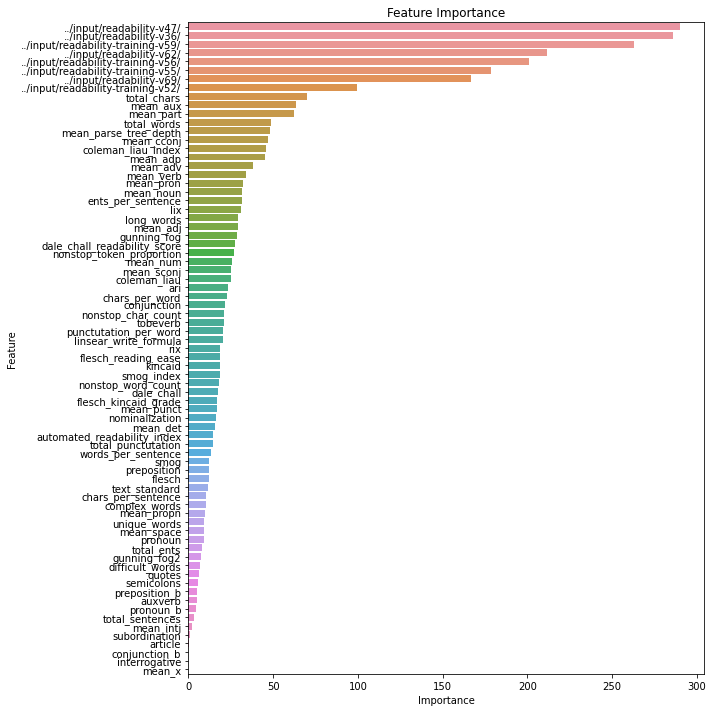

In [27]:
###### FEATURE IMPORTANCE

fig  = plt.figure(figsize = (10, 10))
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False).index
importance = importances.loc[importances.Feature.isin(cols)].groupby('Feature').mean().reset_index(drop = False)
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False), ci = 0)
plt.title('Feature Importance')
plt.tight_layout()

In [28]:
######## BLEND FOLD PREDICTIONS

# copy predictions
test_preds_lgb       = all_lgb_preds.copy()
test_preds_lgb['id'] = sub['id']

# blend folds
print('Blending fold predictions with: ' + CFG['fold_blend'])
for rep in range(CFG['lgb_reps']):
    preds = ['lgb_rep' + str(rep) + '_fold' + str(fold) for fold in range(CFG['lgb_folds'])]
    test_preds_lgb['lgb_rep' + str(rep)] = compute_blend(test_preds_lgb, preds, CFG['fold_blend'], CFG)
    test_preds_lgb.drop(preds, axis = 1, inplace = True)
test_preds_lgb.head()

Blending fold predictions with: amean


,id,lgb_rep0,lgb_rep1,lgb_rep2
0,c0f722661,-0.347026,-0.355782,-0.353793
1,f0953f0a5,-0.560983,-0.566695,-0.547930
2,0df072751,-0.383909,-0.381284,-0.399454
3,04caf4e0c,-2.494757,-2.477678,-2.445026
4,0e63f8bea,-1.840127,-1.818459,-1.857208


In [29]:
######## BLEND BAG PREDICTIONS

print('Blending bag predictions with: ' + CFG['rep_blend'])
preds                  = test_preds_lgb.filter(like = 'lgb').columns
test_preds_lgb['pred'] = compute_blend(test_preds_lgb, preds, CFG['rep_blend'], CFG)
test_preds_lgb.drop(preds, axis = 1, inplace = True)
test_preds_lgb.head()

Blending bag predictions with: amean


,id,pred
0,c0f722661,-0.352200
1,f0953f0a5,-0.558536
2,0df072751,-0.388216
3,04caf4e0c,-2.472487
4,0e63f8bea,-1.838598


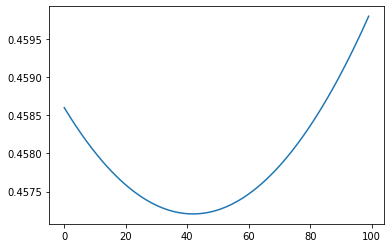


- optimal weight of stacking:   0.4200
- RMSE of blend-stack ensemble: 0.4572


In [30]:
####### OPTIMAL STACKING WEIGHT

# placeholders
score_steps = 100
scores      = []

# optimize stacking weight
for a in range(score_steps):
    w    = a / score_steps
    pred = oof_preds.mean(axis = 1) * w + oof_blend['pred'] * (1 - w)
    scores.append(get_score(y, pred))
plt.plot(scores)
plt.show()

# feedback
w_stack = scores.index(min(scores)) / score_steps
print('')
print('- optimal weight of stacking:   {:.4f}'.format(w_stack))
print('- RMSE of blend-stack ensemble: {:.4f}'.format(min(scores)))

# SUBMISSION

In [31]:
####### ENSEMBLING BLEND AND STACKING

print('Ensembling: {:.2f} * blend + {:.2f} * stacking'.format(1 - CFG['w_stack'], CFG['w_stack']))
test_preds = test_preds_nn.copy()
test_preds['pred'] = test_preds_nn['pred'] * (1 - CFG['w_stack']) + test_preds_lgb['pred'] * CFG['w_stack']
test_preds.head()

Ensembling: 1.00 * blend + 0.00 * stacking


,id,../input/readability-training-v56/,../input/readability-training-v55/,../input/readability-training-v52/,../input/readability-v62/,../input/readability-v36/,../input/readability-v47/,../input/readability-v69/,../input/readability-training-v59/,pred
0,c0f722661,-0.407019,-0.418115,-0.428809,-0.417407,-0.363428,-0.569788,-0.336011,-0.313513,-0.406761
1,f0953f0a5,-0.775049,-0.650342,-0.656812,-0.406238,-0.452954,-0.715674,-0.301917,-0.492480,-0.556433
2,0df072751,-0.399255,-0.423889,-0.453345,-0.415808,-0.413208,-0.376318,-0.374390,-0.365051,-0.402658
3,04caf4e0c,-2.496289,-2.488867,-2.459375,-2.241211,-2.279492,-2.507227,-2.159277,-2.533789,-2.395691
4,0e63f8bea,-1.726758,-1.779590,-1.770117,-1.858301,-1.881738,-1.788184,-1.840430,-1.871289,-1.814551


In [32]:
####### SUBMISSION FILE

if all_counter == len(CFG['models'] * CFG['use_folds'] * CFG['use_reps']):
    sub = test_preds[['id', 'pred']].copy()   
    sub.columns = ['id', 'target']
    sub['target'] = np.clip(sub['target'].values, CFG['clip'][0], CFG['clip'][1])
    sub.to_csv(CFG['out_path'] + 'submission.csv', index = False)
    display(sub.head())

,id,target
0,c0f722661,-0.406761
1,f0953f0a5,-0.556433
2,0df072751,-0.402658
3,04caf4e0c,-2.395691
4,0e63f8bea,-1.814551


# PUBLIC KERNELS

## MODEL 1 [5]

In [33]:
if CFG['w_public'] > 0:

    import os
    import math
    import random
    import time

    import numpy as np
    import pandas as pd

    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader

    from transformers import AutoTokenizer
    from transformers import AutoModel
    from transformers import AutoConfig

    from sklearn.model_selection import KFold
    from sklearn.svm import SVR

    import gc
    gc.enable()


    BATCH_SIZE     = 32
    MAX_LEN        = 248
    EVAL_SCHEDULE  = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
    ROBERTA_PATH   = "/kaggle/input/transformers/roberta-base"
    TOKENIZER_PATH = "/kaggle/input/transformers/roberta-base"
    DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"

    test_df       = pd.read_csv("/kaggle/input/commonlitreadabilityprize/test.csv")
    submission_df = pd.read_csv("/kaggle/input/commonlitreadabilityprize/sample_submission.csv")
    tokenizer     = AutoTokenizer.from_pretrained(TOKENIZER_PATH)


    class LitDataset(Dataset):
        def __init__(self, df, inference_only=False):
            super().__init__()

            self.df = df        
            self.inference_only = inference_only
            self.text = df.excerpt.tolist()
            #self.text = [text.replace("\n", " ") for text in self.text]

            if not self.inference_only:
                self.target = torch.tensor(df.target.values, dtype=torch.float32)        

            self.encoded = tokenizer.batch_encode_plus(
                self.text,
                padding = 'max_length',            
                max_length = MAX_LEN,
                truncation = True,
                return_attention_mask=True
            )        


        def __len__(self):
            return len(self.df)


        def __getitem__(self, index):        
            input_ids = torch.tensor(self.encoded['input_ids'][index])
            attention_mask = torch.tensor(self.encoded['attention_mask'][index])

            if self.inference_only:
                return (input_ids, attention_mask)            
            else:
                target = self.target[index]
                return (input_ids, attention_mask, target)


    class LitModel(nn.Module):
        def __init__(self):
            super().__init__()

            config = AutoConfig.from_pretrained(ROBERTA_PATH)
            config.update({"output_hidden_states":True, 
                           "hidden_dropout_prob": 0.0,
                           "layer_norm_eps": 1e-7})                       

            self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config)  

            self.attention = nn.Sequential(            
                nn.Linear(768, 512),            
                nn.Tanh(),                       
                nn.Linear(512, 1),
                nn.Softmax(dim=1)
            )        

            self.regressor = nn.Sequential(                        
                nn.Linear(768, 1)                        
            )


        def forward(self, input_ids, attention_mask):
            roberta_output = self.roberta(input_ids=input_ids,
                                          attention_mask=attention_mask)        

            # There are a total of 13 layers of hidden states.
            # 1 for the embedding layer, and 12 for the 12 Roberta layers.
            # We take the hidden states from the last Roberta layer.
            last_layer_hidden_states = roberta_output.hidden_states[-1]

            # The number of cells is MAX_LEN.
            # The size of the hidden state of each cell is 768 (for roberta-base).
            # In order to condense hidden states of all cells to a context vector,
            # we compute a weighted average of the hidden states of all cells.
            # We compute the weight of each cell, using the attention neural network.
            weights = self.attention(last_layer_hidden_states)

            # weights.shape is BATCH_SIZE x MAX_LEN x 1
            # last_layer_hidden_states.shape is BATCH_SIZE x MAX_LEN x 768        
            # Now we compute context_vector as the weighted average.
            # context_vector.shape is BATCH_SIZE x 768
            context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        

            # Now we reduce the context vector to the prediction score.
            return self.regressor(context_vector)


    def predict(model, data_loader):
        """Returns an np.array with predictions of the |model| on |data_loader|"""
        model.eval()

        result = np.zeros(len(data_loader.dataset))    
        index = 0

        with torch.no_grad():
            for batch_num, (input_ids, attention_mask) in enumerate(data_loader):
                input_ids = input_ids.to(DEVICE)
                attention_mask = attention_mask.to(DEVICE)

                pred = model(input_ids, attention_mask)                        

                result[index : index + pred.shape[0]] = pred.flatten().to("cpu")
                index += pred.shape[0]

        return result


    NUM_MODELS = 5

    all_predictions = np.zeros((NUM_MODELS, len(test_df)))
    test_dataset    = LitDataset(test_df, inference_only=True)
    test_loader     = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             drop_last=False, shuffle=False, num_workers=2)

    for model_index in range(NUM_MODELS):            
        model_path = f"../input/commonlit-roberta-0467/model_{model_index + 1}.pth"
        print(f"\nUsing {model_path}")

        model = LitModel()
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))    
        model.to(DEVICE)

        all_predictions[model_index] = predict(model, test_loader)

        del model
        gc.collect()


    model1_predictions = all_predictions.mean(axis = 0)


Using ../input/commonlit-roberta-0467/model_1.pth


Some weights of the model checkpoint at /kaggle/input/transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Using ../input/commonlit-roberta-0467/model_2.pth


Some weights of the model checkpoint at /kaggle/input/transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Using ../input/commonlit-roberta-0467/model_3.pth


Some weights of the model checkpoint at /kaggle/input/transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Using ../input/commonlit-roberta-0467/model_4.pth


Some weights of the model checkpoint at /kaggle/input/transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Using ../input/commonlit-roberta-0467/model_5.pth


Some weights of the model checkpoint at /kaggle/input/transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## MODEL 2 [15]

In [34]:
if CFG['w_public'] > 0:

    test = test_df

    from glob import glob
    import os
    import matplotlib.pyplot as plt
    import json
    from collections import defaultdict

    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    from torch.optim.optimizer import Optimizer
    import torch.optim.lr_scheduler as lr_scheduler
    from torch.utils.data import (
        Dataset, DataLoader, 
        SequentialSampler, RandomSampler
    )
    from transformers import RobertaConfig
    from transformers import (
        get_cosine_schedule_with_warmup, 
        get_cosine_with_hard_restarts_schedule_with_warmup
    )
    from transformers import RobertaTokenizer
    from transformers import RobertaModel
    from IPython.display import clear_output
    from tqdm import tqdm, trange


    def convert_examples_to_features(data, tokenizer, max_len, is_test=False):
        data = data.replace('\n', '')
        tok = tokenizer.encode_plus(
            data, 
            max_length=max_len, 
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
        )
        curr_sent = {}
        padding_length = max_len - len(tok['input_ids'])
        curr_sent['input_ids'] = tok['input_ids'] + ([0] * padding_length)
        curr_sent['token_type_ids'] = tok['token_type_ids'] + \
            ([0] * padding_length)
        curr_sent['attention_mask'] = tok['attention_mask'] + \
            ([0] * padding_length)
        return curr_sent


    class DatasetRetriever(Dataset):
        def __init__(self, data, tokenizer, max_len, is_test=False):
            self.data = data
            self.excerpts = self.data.excerpt.values.tolist()
            self.tokenizer = tokenizer
            self.is_test = is_test
            self.max_len = max_len

        def __len__(self):
            return len(self.data)

        def __getitem__(self, item):
            if not self.is_test:
                excerpt, label = self.excerpts[item], self.targets[item]
                features = convert_examples_to_features(
                    excerpt, self.tokenizer, 
                    self.max_len, self.is_test
                )
                return {
                    'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                    'token_type_ids':torch.tensor(features['token_type_ids'], dtype=torch.long),
                    'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
                    'label':torch.tensor(label, dtype=torch.double),
                }
            else:
                excerpt = self.excerpts[item]
                features = convert_examples_to_features(
                    excerpt, self.tokenizer, 
                    self.max_len, self.is_test
                )
                return {
                    'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                    'token_type_ids':torch.tensor(features['token_type_ids'], dtype=torch.long),
                    'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
                }


    class CommonLitModel(nn.Module):
        def __init__(
            self, 
            model_name, 
            config,  
            multisample_dropout=False,
            output_hidden_states=False
        ):
            super(CommonLitModel, self).__init__()
            self.config = config
            self.roberta = RobertaModel.from_pretrained(
                model_name, 
                output_hidden_states=output_hidden_states
            )
            self.layer_norm = nn.LayerNorm(config.hidden_size)
            if multisample_dropout:
                self.dropouts = nn.ModuleList([
                    nn.Dropout(0.5) for _ in range(5)
                ])
            else:
                self.dropouts = nn.ModuleList([nn.Dropout(0.3)])
            self.regressor = nn.Linear(config.hidden_size, 1)
            self._init_weights(self.layer_norm)
            self._init_weights(self.regressor)

        def _init_weights(self, module):
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)

        def forward(
            self, 
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            labels=None
        ):
            outputs = self.roberta(
                input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            sequence_output = outputs[1]
            sequence_output = self.layer_norm(sequence_output)

            # multi-sample dropout
            for i, dropout in enumerate(self.dropouts):
                if i == 0:
                    logits = self.regressor(dropout(sequence_output))
                else:
                    logits += self.regressor(dropout(sequence_output))

            logits /= len(self.dropouts)

            # calculate loss
            loss = None
            if labels is not None:
                loss_fn = torch.nn.MSELoss()
                logits = logits.view(-1).to(labels.dtype)
                loss = torch.sqrt(loss_fn(logits, labels.view(-1)))

            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output


    def make_model(model_name, num_labels=1):
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        config    = RobertaConfig.from_pretrained(model_name)
        config.update({'num_labels':num_labels})
        model = CommonLitModel(model_name, config=config)
        return model, tokenizer

    def make_loader(
        data, 
        tokenizer, 
        max_len,
        batch_size,
    ):

        test_dataset = DatasetRetriever(data, tokenizer, max_len, is_test=True)
        test_sampler = SequentialSampler(test_dataset)
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size // 2, 
            sampler=test_sampler, 
            pin_memory=False, 
            drop_last=False, 
            num_workers=0
        )

        return test_loader


    class Evaluator:
        def __init__(self, model, scalar=None):
            self.model = model
            self.scalar = scalar

        def evaluate(self, data_loader, tokenizer):
            preds = []
            self.model.eval()
            total_loss = 0
            with torch.no_grad():
                for batch_idx, batch_data in enumerate(data_loader):
                    input_ids, attention_mask, token_type_ids = batch_data['input_ids'], \
                        batch_data['attention_mask'], batch_data['token_type_ids']
                    input_ids, attention_mask, token_type_ids = input_ids.cuda(), \
                        attention_mask.cuda(), token_type_ids.cuda()

                    if self.scalar is not None:
                        with torch.cuda.amp.autocast():
                            outputs = self.model(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids
                            )
                    else:
                        outputs = self.model(
                            input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids
                        )

                    logits = outputs[0].detach().cpu().numpy().squeeze().tolist()
                    preds += logits
            return preds


    def config(fold, model_name, load_model_path):
        torch.manual_seed(2021)
        torch.cuda.manual_seed(2021)
        torch.cuda.manual_seed_all(2021)

        max_len = 250
        batch_size = 8

        model, tokenizer = make_model(
            model_name=model_name, 
            num_labels=1
        )
        model.load_state_dict(
            torch.load(f'{load_model_path}/model{fold}.bin')
        )
        test_loader = make_loader(
            test, tokenizer, max_len=max_len,
            batch_size=batch_size
        )

        if torch.cuda.device_count() >= 1:
            print('Model pushed to {} GPU(s), type {}.'.format(
                torch.cuda.device_count(), 
                torch.cuda.get_device_name(0))
            )
            model = model.cuda() 
        else:
            raise ValueError('CPU training is not supported')

        # scaler = torch.cuda.amp.GradScaler()
        scaler = None
        return (
            model, tokenizer, 
            test_loader, scaler
        )


    def run(fold=0, model_name=None, load_model_path=None):
        model, tokenizer, \
            test_loader, scaler = config(fold, model_name, load_model_path)

        import time

        evaluator = Evaluator(model, scaler)

        test_time_list = []

        torch.cuda.synchronize()
        tic1 = time.time()

        preds = evaluator.evaluate(test_loader, tokenizer)

        torch.cuda.synchronize()
        tic2 = time.time() 
        test_time_list.append(tic2 - tic1)

        del model, tokenizer, test_loader, scaler
        gc.collect()
        torch.cuda.empty_cache()

        return preds


    pred_df1 = pd.DataFrame()
    pred_df2 = pd.DataFrame()
    pred_df3 = pd.DataFrame()

    for fold in tqdm(range(5)):
        pred_df1[f'fold{fold}']    = run(fold, '../input/roberta-base/', '../input/commonlit-roberta-base-i/')
        pred_df2[f'fold{fold+5}']  = run(fold, '../input/robertalarge/', '../input/roberta-large-itptfit/')
        pred_df3[f'fold{fold+10}'] = run(fold, '../input/robertalarge/', '../input/commonlit-roberta-large-ii/')


    pred_df1 = np.array(pred_df1)
    pred_df2 = np.array(pred_df2)
    pred_df3 = np.array(pred_df3)

    model2_predictions = (pred_df2.mean(axis=1) * 1/3) + \
                         (pred_df1.mean(axis=1) * 1/3) + \
                         (pred_df3.mean(axis=1) * 1/3)


  0%|          | 0/5 [00:00<?, ?it/s]Some weights of the model checkpoint at ../input/roberta-base/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.



 20%|██        | 1/5 [01:13<04:52, 73.02s/it]Some weights of the model checkpoint at ../input/roberta-base/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.



 40%|████      | 2/5 [01:59<02:51, 57.23s/it]Some weights of the model checkpoint at ../input/roberta-base/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.



 60%|██████    | 3/5 [02:47<01:46, 53.07s/it]Some weights of the model checkpoint at ../input/roberta-base/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.



 80%|████████  | 4/5 [03:29<00:48, 48.74s/it]Some weights of the model checkpoint at ../input/roberta-base/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.


Some weights of the model checkpoint at ../input/robertalarge/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla P100-PCIE-16GB.



100%|██████████| 5/5 [04:10<00:00, 50.06s/it]


## MODEL 3 [5]

In [35]:
if CFG['w_public'] > 0:  

    import os
    import numpy as np
    import pandas as pd
    import random

    from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, logging

    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, TensorDataset, SequentialSampler, RandomSampler, DataLoader

    from tqdm.notebook import tqdm

    import gc; gc.enable()
    from IPython.display import clear_output

    from sklearn.model_selection import StratifiedKFold
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_style('whitegrid')
    logging.set_verbosity_error()


    INPUT_DIR      = '../input/commonlitreadabilityprize'
    MODEL_DIR      = '../input/transformers/roberta-large'
    CHECKPOINT_DIR = '../input/clrp-mean-pooling/'

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    MAX_LENGTH = 248
    TEST_BATCH_SIZE = 1
    HIDDEN_SIZE = 1024

    NUM_FOLDS = 5
    SEEDS = [113]

    test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))


    class MeanPoolingModel(nn.Module):

        def __init__(self, model_name):
            super().__init__()

            config = AutoConfig.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name, config=config)
            self.linear = nn.Linear(HIDDEN_SIZE, 1)
            self.loss = nn.MSELoss()

        def forward(self, input_ids, attention_mask, labels=None):

            outputs = self.model(input_ids, attention_mask)
            last_hidden_state = outputs[0]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            logits = self.linear(mean_embeddings)

            preds = logits.squeeze(-1).squeeze(-1)

            if labels is not None:
                loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
                return loss
            else:
                return preds


    def get_test_loader(data):

        x_test = data.excerpt.tolist()

        tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

        encoded_test = tokenizer.batch_encode_plus(
            x_test, 
            add_special_tokens=True, 
            return_attention_mask=True, 
            padding='max_length', 
            truncation=True,
            max_length=MAX_LENGTH, 
            return_tensors='pt'
        )

        dataset_test = TensorDataset(
            encoded_test['input_ids'],
            encoded_test['attention_mask']
        )

        dataloader_test = DataLoader(
            dataset_test,
            sampler = SequentialSampler(dataset_test),
            batch_size=TEST_BATCH_SIZE
        )

        return dataloader_test

    test_dataloader = get_test_loader(test)


    all_predictions = []
    for seed in SEEDS:

        fold_predictions = []

        for fold in tqdm(range(NUM_FOLDS)):
            model_path = f"model_{seed + 1}_{fold + 1}.pth"

            print(f"\nUsing {model_path}")

            model_path = CHECKPOINT_DIR + f"model_{seed + 1}_{fold + 1}.pth"
            model = MeanPoolingModel(MODEL_DIR)
            model.load_state_dict(torch.load(model_path)) 
            model.to(DEVICE)
            model.eval()

            predictions = []
            for batch in test_dataloader:

                batch = tuple(b.to(DEVICE) for b in batch)

                inputs = {'input_ids':      batch[0],
                          'attention_mask': batch[1],
                          'labels':         None,
                         }

                preds = model(**inputs).item()
                predictions.append(preds)

            del model 
            gc.collect()

            fold_predictions.append(predictions)
        all_predictions.append(np.mean(fold_predictions, axis=0).tolist())

    model3_predictions = np.mean(all_predictions,axis = 0)

  0%|          | 0/5 [00:00<?, ?it/s]


Using model_114_1.pth

Using model_114_2.pth

Using model_114_3.pth

Using model_114_4.pth

Using model_114_5.pth


In [36]:
if CFG['w_public'] > 0:  

    predictions = model1_predictions * (1/3) + model2_predictions * (1/3) + model3_predictions * (1/3)
    print(predictions[0:10])

[-0.42785269 -0.53396597 -0.42449434 -2.38692547 -1.78933372 -1.22127291
  0.10485552]


# FINAL BLEND

In [37]:
####### SUBMISSION FILE

if CFG['w_public'] > 0:

    print('Ensembling: {:.2f} * my + {:.2f} * public'.format(1 - CFG['w_public'], CFG['w_public']))
    sub           = pd.read_csv(CFG['out_path'] + 'submission.csv')
    sub['target'] = (1 - CFG['w_public']) * sub['target'] + CFG['w_public'] * predictions
    sub.to_csv(CFG['out_path'] + 'submission.csv', index = False)
    display(sub.head())

Ensembling: 0.80 * my + 0.20 * public


,id,target
0,c0f722661,-0.410979
1,f0953f0a5,-0.551940
2,0df072751,-0.407025
3,04caf4e0c,-2.393938
4,0e63f8bea,-1.809507
